In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))


%matplotlib notebook
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import datetime
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy

pd.set_option('display.max_rows', 200)    


Using TensorFlow backend.
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cshul

# Raw data Paths
using Streamflow data direclty obtained from cshuler/ASPA-UH_Integrated_Modeling_Framework

In [2]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Stream_REPO/workspace/All_consolodated_Q_m3ps.csv"
save_to = os.path.join(".", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16200025

# read in data and convert to daily average values

<IPython.core.display.Javascript object>


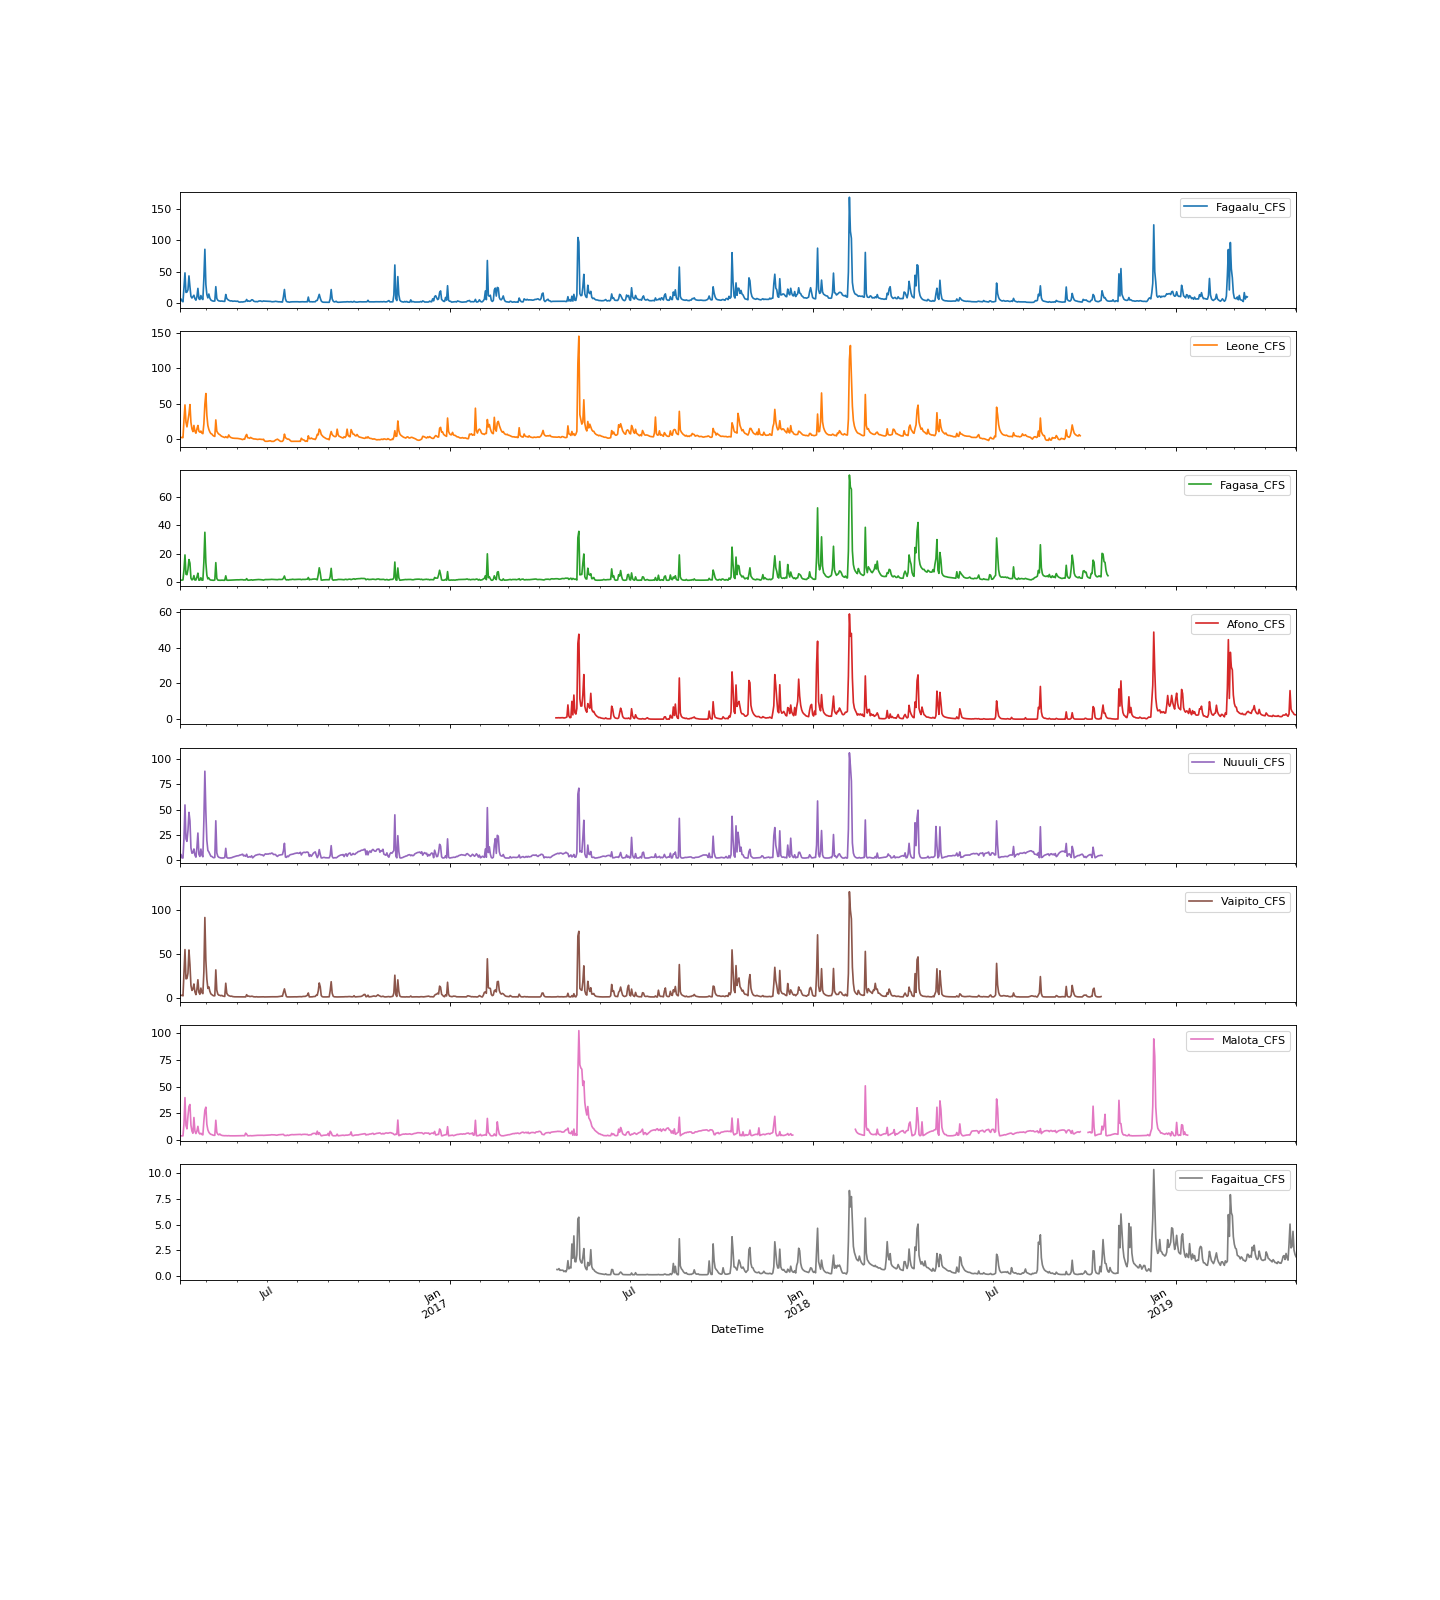

In [3]:
rawdata = pd.read_csv(save_to ,index_col=0,parse_dates=True)

dat = rawdata.resample('D').mean()     # subsample the 15 min data into daily values
dat = dat[8:]                          # this just to cut out some of the beginning days with no streamflows

data = pd.DataFrame(index=dat.index)
for column in dat:
    new_name = column.split("_")[0]+"_CFS"
    data[new_name] = dat[column]*35.314666212661 
    
data.plot(subplots=True, figsize=(18, 20)); plt.legend(loc='best')

# examine corelation matrix to see relationships between stations 

note that maloata station is poorly correlated, this is likey due to the station being messed up, so remove it. 


<IPython.core.display.Javascript object>


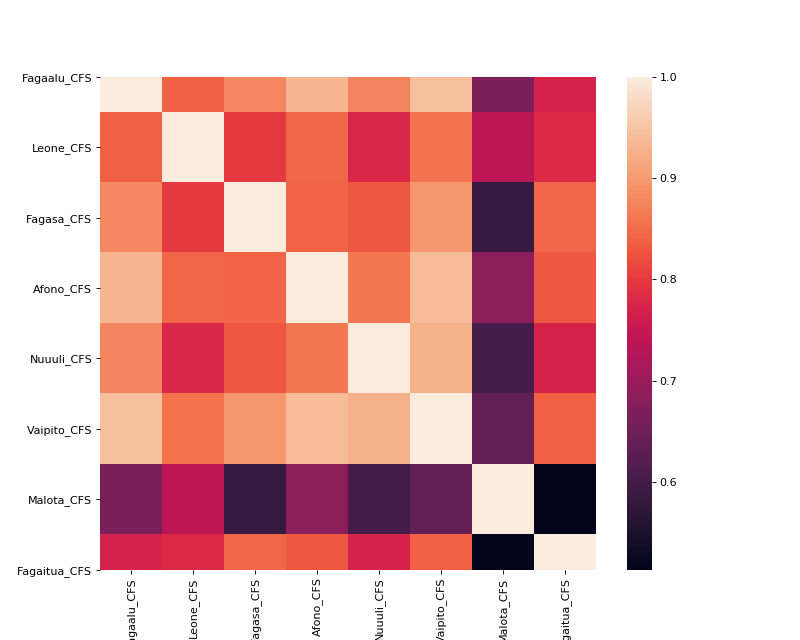

In [4]:
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values)

<IPython.core.display.Javascript object>


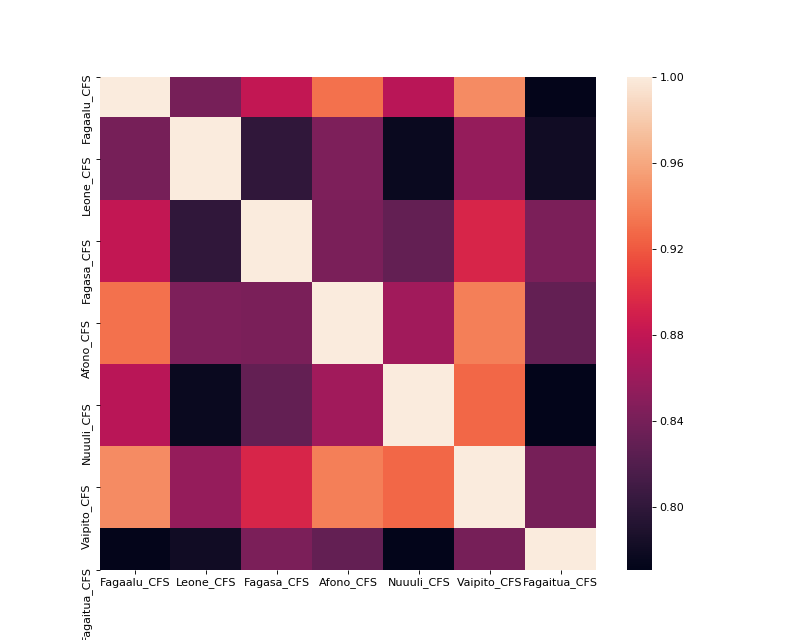

In [5]:
## remove Maloata from data  new plot
data = data.loc[:, data.columns != 'Malota_CFS']

plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values)

# Define what data ranges to use now

In [ ]:
# some syntax....
print("First Date = {}".format(min(data.index)))
print("Last Date = {}".format(max(data.index)))
data.columns

In [ ]:
#Definition of training sets
Train_Start = '2017-04-18'
Train_End = '2018-09-12'


X_train = data.loc[Train_Start:Train_End,['Nuuuli_CFS','Leone_CFS', 'Fagasa_CFS', 'Vaipito_CFS']].values   
y_train = data.loc[Train_Start:Train_End,'Afono_CFS'].values # Est 2

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# initilize the DL model 

In [ ]:
model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(4,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

In [ ]:
# train the network
model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
model.fit(X_train, y_train,epochs=600, verbose=1)

In [ ]:
# plot time series
y_pred = model.predict(X_train)

fig1 = plt.figure(figsize=(15, 5))
plt.plot(data.loc[Train_Start:Train_End].index, y_pred,label='Predicted')
data['Afono_CFS'].loc[Train_Start:Train_End].plot()
plt.legend(loc='best')

# plot and analyze comparison
x = np.squeeze(data['Afono_CFS'].loc[Train_Start:Train_End].values)
y = np.squeeze(y_pred)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)                              # get stats on regression
mea = np.mean(np.abs(x-y)); rmse = np.sqrt(np.mean(np.abs(x-y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error

fig2 = plt.figure(figsize=(5, 5))
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
plt.scatter(x, y, label="r2={0:1.2f}, slope={1:1.2f}, RMSE={2:1.2f}".format(r_value, slope, rmse))                                                                                       # plot dots
plt.legend()

print ('RMSE Error: {:.2f}\nr2: {:.2f}\nslope : {:.2f}'.format(rmse, r_value, slope ))

# predict missing data 

In [ ]:


#Get the prediction for the train set
X_missing = data.loc['2016-04-5':'2017-04-17',['Nuuuli_CFS','Leone_CFS', 'Fagasa_CFS', 'Vaipito_CFS']].values   

# Define the scaler 
scaler = StandardScaler().fit(X_missing)

# Scale the train set
X_missing = scaler.transform(X_missing)



y_missing = model.predict(X_missing)
y_missing = y_missing.reshape([378]).tolist()


data['Afono_Completed']=data['Afono_CFS']
data['Afono_Completed'].loc['2016-04-5':'2017-04-17'] = y_missing

data.loc['2016-04-05':'2018-09-27',['Leone_CFS','Nuuuli_CFS','Afono_Completed','Afono_CFS']].plot(subplots=True,  figsize=(15, 10)); plt.legend(loc='best')


#### crazy loopynes

gap filling for station Fagaalu_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS']


<IPython.core.display.Javascript object>


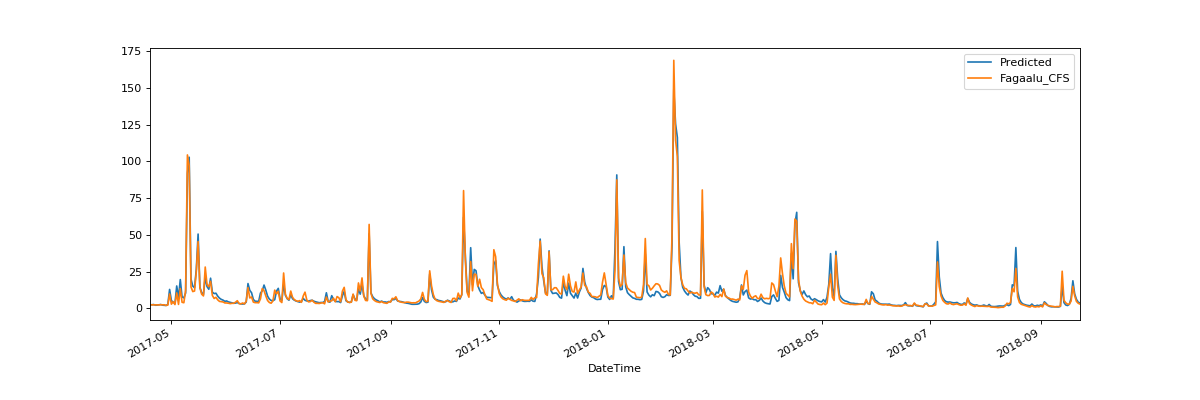

<IPython.core.display.Javascript object>


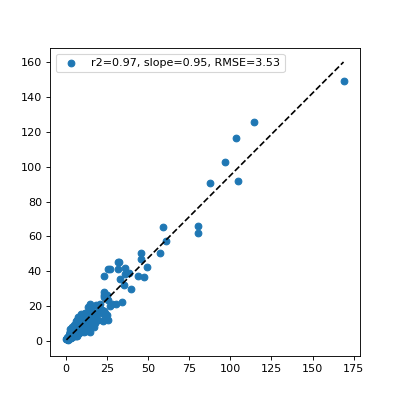

RMSE Error: 3.53
r2: 0.97
slope : 0.95
gap filling for station Leone_CFS
Training with stations ['Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


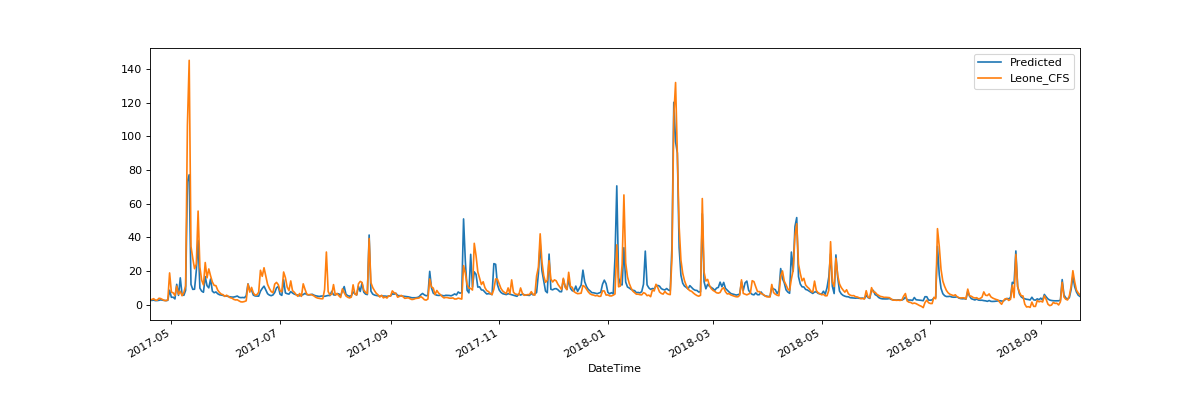

<IPython.core.display.Javascript object>


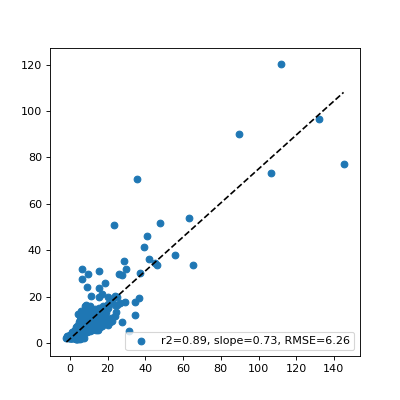

RMSE Error: 6.26
r2: 0.89
slope : 0.73
gap filling for station Fagasa_CFS
Training with stations ['Fagaalu_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


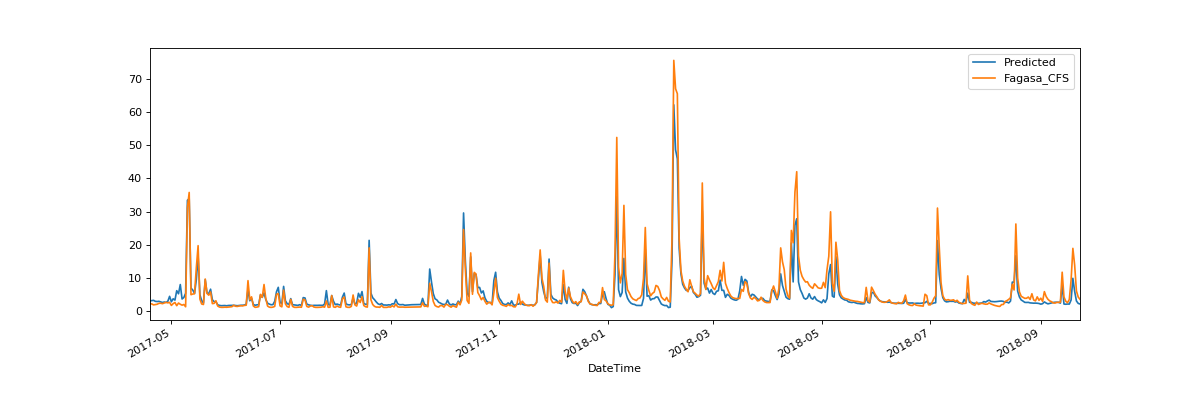

<IPython.core.display.Javascript object>


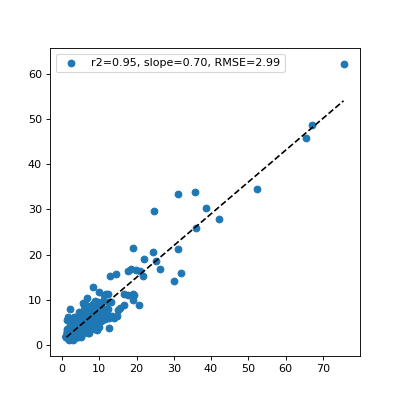

RMSE Error: 2.99
r2: 0.95
slope : 0.70
gap filling for station Afono_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


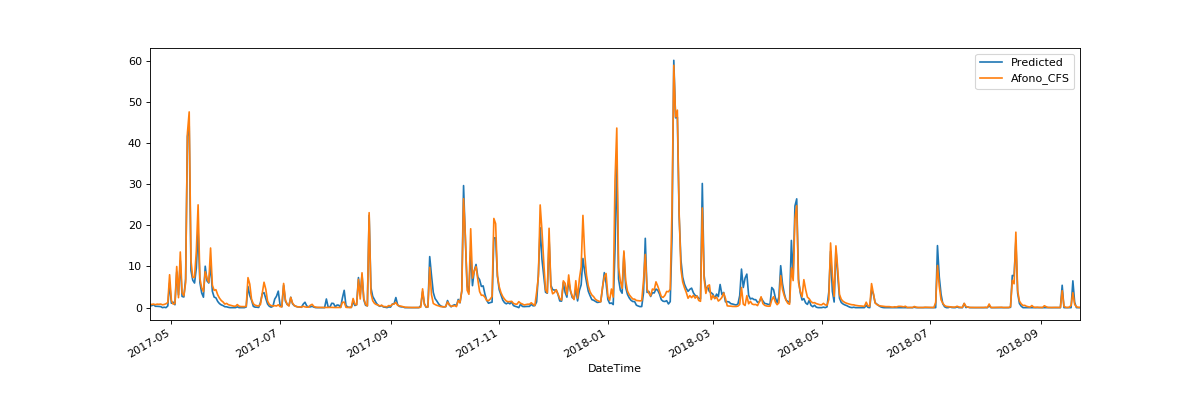

<IPython.core.display.Javascript object>


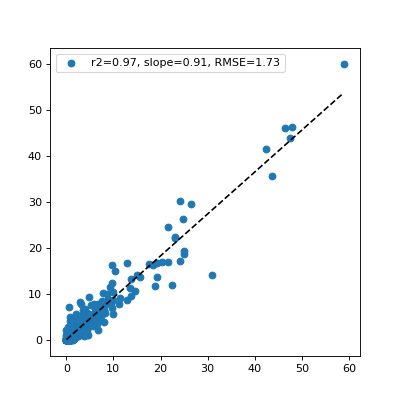

RMSE Error: 1.73
r2: 0.97
slope : 0.91
gap filling for station Nuuuli_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


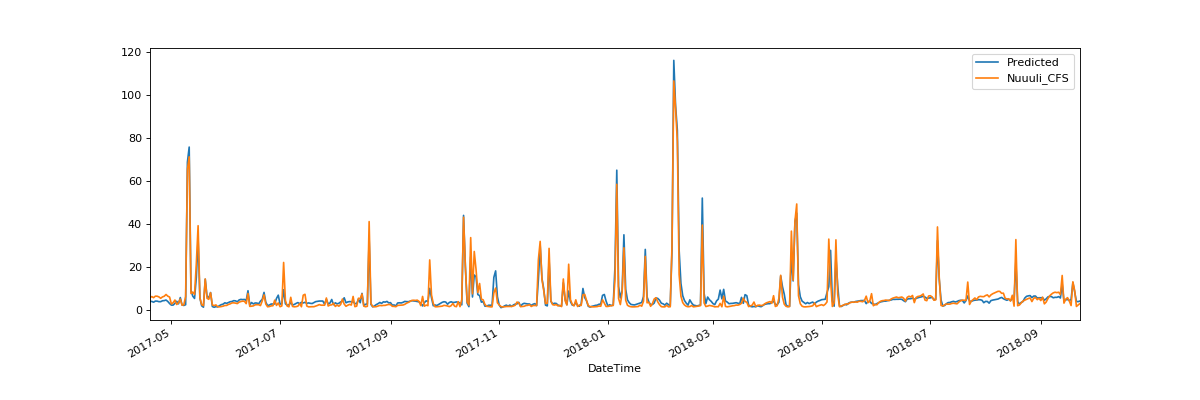

<IPython.core.display.Javascript object>


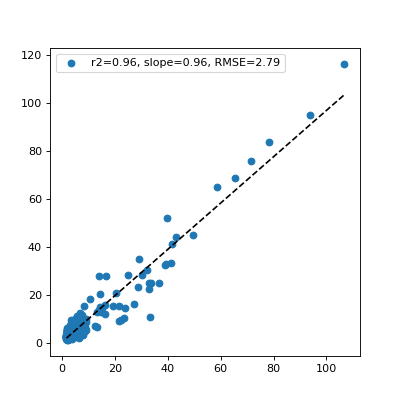

RMSE Error: 2.79
r2: 0.96
slope : 0.96
gap filling for station Vaipito_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


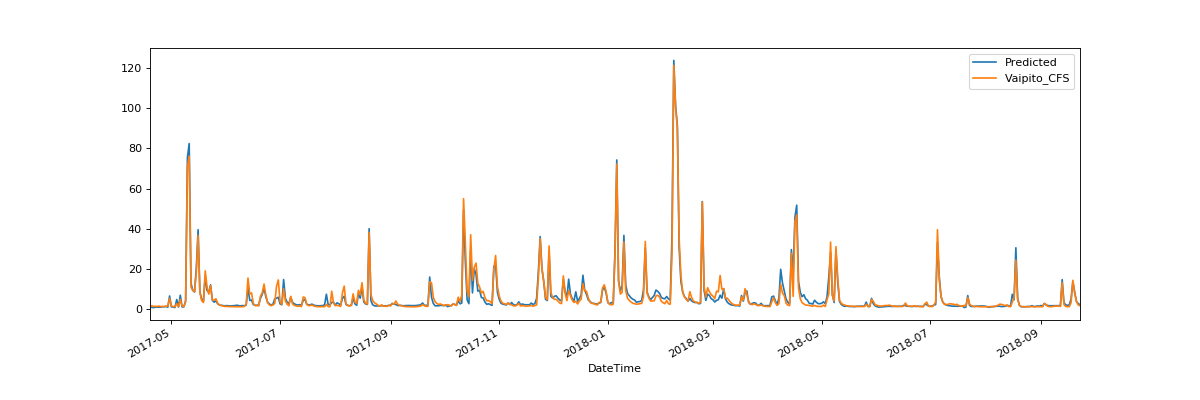

<IPython.core.display.Javascript object>


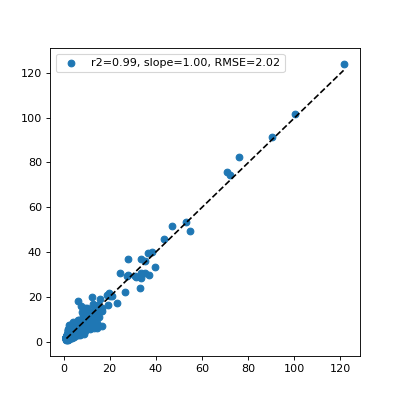

RMSE Error: 2.02
r2: 0.99
slope : 1.00
gap filling for station Fagaitua_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


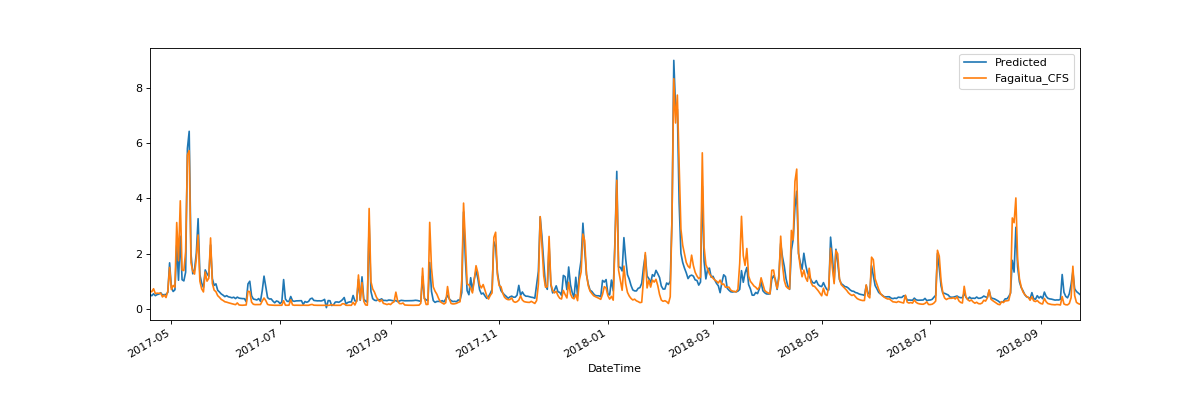

<IPython.core.display.Javascript object>


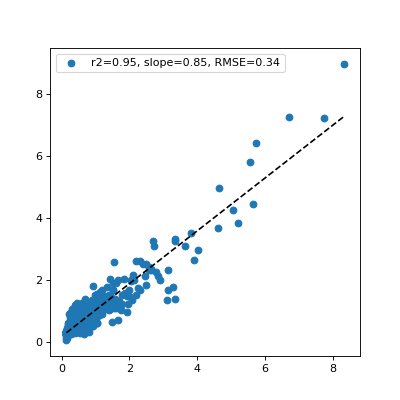

RMSE Error: 0.34
r2: 0.95
slope : 0.85


In [11]:
# make sure that maloata is gone
data = data.loc[:, data.columns != 'Malota_CFS']

# just select perfect no gap dataset 
data_all = data.dropna()




station_list = list(data_all.columns)

for i in station_list:
    
    
    print("gap filling for station {}".format(i))
    print("Training with stations {}".format(trainlist))
    
    trainlist = station_list.copy()                 # the list of all the other stations with which to use to train the network
    trainlist.remove(i)           
    
    # some math to be able to select a portion of the dataset, based upon a percentage (0-1)of the data we want to remove   ( can loop over how_much_to_delete variable later)
    n = len(data_all[i])
    how_much_to_delete = .01                       # Has to be   0 < x < 1  cant be 0 or 1. 
    stop_idx = n-int((how_much_to_delete)*n)
    Train_End = data_all.index[stop_idx]                # end of the training data period, i.e. training data omits data after this data 
    Train_Start = data_all.index[0]                      # start of the training data period (always the beginning of data all 
    
    X_train = data.loc[Train_Start:Train_End,trainlist].values   
    y_train = data.loc[Train_Start:Train_End,i].values  
    
    #scale values appropriately
    scaler = StandardScaler().fit(X_train)   # Define the scaler 
    X_train = scaler.transform(X_train) # Scale the train set
    
    model = Sequential()

    model.add(Dense(100, activation='relu', input_shape=(len(trainlist),)))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='relu'))
    #model.summary()
    
    # train the network
    model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
    model.fit(X_train, y_train,epochs=10, verbose=0)
    
    
        # plot time series
    y_pred = model.predict(X_train)

    fig1 = plt.figure(figsize=(15, 5))
    plt.plot(data.loc[Train_Start:Train_End].index, y_pred,label='Predicted')
    data[i].loc[Train_Start:Train_End].plot()
    plt.legend(loc='best')

    # plot and analyze comparison
    x = np.squeeze(data[i].loc[Train_Start:Train_End].values)
    y = np.squeeze(y_pred)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)                              # get stats on regression
    mea = np.mean(np.abs(x-y)); rmse = np.sqrt(np.mean(np.abs(x-y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error

    fig2 = plt.figure(figsize=(5, 5))
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
    plt.scatter(x, y, label="r2={0:1.2f}, slope={1:1.2f}, RMSE={2:1.2f}".format(r_value, slope, rmse))                                                                                       # plot dots
    plt.legend()

    print ('RMSE Error: {:.2f}\nr2: {:.2f}\nslope : {:.2f}'.format(rmse, r_value, slope ))


### half way there, no need to convert to plotting the valudataion data 

In [ ]:
set up validataion test: 
process: 
1) make data all perfect no gap dataset. 
2) for each column (site) 
   2.1 select 5% of data, and remove 
   2.2 use remaining coluns with the existing data in the selected column as training data 
   2.3 train the network (that is the same as the model being used in the script) 


In [ ]:
goal for next: 
    figure out how to use multivariate data, (such as topography, or rainfall, soil, and land use) to predict streamflow
    


Hows this for a project, 
- use DL with the same data given to SWAT and compare output. for my streams using the streamflow data for validation. 


motivation: deep learning techniques are opening up new frontiers in prediction of natural systems. Previoulsy we have relied on physical models like SWAT, however with increasing data sensity and decreasing costs of sensors , loggers and infrastructure to create large data sets, machiene learning techniques are now widely known to be able to recognize things that we as humand cant account for with physical models 

hypothesis: 

In [ ]:
data_all.to_csv('dataall.csv')